# Building the Machine Learning Models

During EDA we found out that, with regards to statistical measures in this exercise (PTS, STL, AST, BLK etc), NBA centers from the US and EU are essentially the same. Put another way, the statistical measures for (which we will build our predictive models) are independant of the 'US or EU' column. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
plt.rcParams["figure.figsize"] = [18,10]

with open("C:/Users/Lukas Buteliauskas/Desktop/Springboard Projects/Capstone Project 1 - NBA Analytics/"
          "3. Exploratory Data Analysis/Player Data Filtered.csv", "r") as player_data_file:
    player_data_df=pd.read_csv(player_data_file)
    
player_data_df_undrafted=player_data_df[player_data_df["Draft Placing"].isnull()].reset_index(drop=True) #undrafted player data
player_data_df=player_data_df[player_data_df["Draft Placing"].isnull()==False].reset_index(drop=True) # drafted player data

player_data_og=player_data_df # keeping a copy of the input data (for drafted players)
player_data_df=player_data_df.loc[(player_data_df["eFG%"]!=0.0) & (player_data_df["eFG%"]!=100.0)] # filtering out 0 or 100 eFG%
player_data_df=player_data_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,13]].reset_index(drop=True) #dropping US or EU

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Given that undrafted players make up a sizeable amount of data, and are themselves a specific group of players, their data cannot be disregarded, but at the same time the Draft Rank cannot be reverse engineered. Hence, it makes sense to consider both groups as distinct, and attempt to build models for both seperately. We will begin with models for drafted players.

### Defining the Classifier Performance Printing/Testing Functions

In [15]:
def performance_prints(clf, X_train, X_test, y_train, y_test, cv=5, n_test_print=20): # some performance/test prints
    print("Training performance (R^2): %.3f" % clf.score(X_train, y_train))
    print("Testing performance (R^2): %.3f" % clf.score(X_test, y_test))
    scores=cross_val_score(clf, X_train, y_train, cv=cv)
    print("R^2 cross val mean: %.3f" % (scores.mean()))
    print("95%% confidence interval for R^2: (%.3f, %.3f)" % (scores.mean()-scores.std()*2, scores.mean()+scores.std()*2))
    print("Mean Squared Error (MSE): %.3f\n\nSome test prints:" % mean_squared_error(y_test, y_pred))

    for idx, data in enumerate(zip(y_test, y_pred)): 
        if idx<n_test_print:
            print("Actual: %.2f\t  Predicted: %.2f\tDifference (absolute): %.3f" % (data[0], data[1], np.abs(data[0]-data[1])))
            
def my_resid_plot(y_test, y_pred, label_name="", standardized=False, het_plot=False): # for showing us the residual plots
    residuals=y_test-y_pred
    if standardized is True:
        residuals/=np.std(residuals)
        plt.scatter(y_pred, residuals, color="black")
        plt.title("Residual Plot")
        plt.xlabel("Predicted " + label_name + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show()
    else:
        plt.scatter(y_pred, residuals, color="black")
        plt.title("Residual Plot")
        plt.xlabel("Predicted " + label_name + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show()
    if het_plot is True:
        sns.lmplot("Predicted Values","Residuals", data=pd.DataFrame({"Predicted Values":y_pred, "Residuals":residuals}),
                                                           size=10, aspect=1.5)
        plt.title("Heteroscedasticity Test")
        plt.show()
    
def my_resid_plots(y_test, y_pred, X_test, columns):
    residuals=y_test-y_pred
    print("Heteroscendasticity hypothesis test p value:", het_breuschpagan(resid=residuals, exog_het=X_test)[1])
    for idx, column in enumerate(columns):
        plt.scatter(X_test[:,idx], residuals, color="black")
        plt.title("Residual Plot for "+ column)
        plt.xlabel(column + " Values")
        plt.ylabel("Residuals")
        plt.axhline(y=0, linewidth=3, color="black")
        plt.show() 
    
def prediction_plot(y_test, y_pred, label_name=""): # for showing actual values vs predicted values
    plt.scatter(y_test, y_pred, color="black")
    plt.title("Actual vs Predicted " + label_name + " Plot")
    plt.xlabel("Actual " + label_name + " Values")
    plt.ylabel("Predicted " + label_name + " Values")
    plt.show()
    
def my_normalizer(df, columns_print=False): # transform the independant variables (if tranformable), return normalised dataframe
    new_df=df
    transformed_columns=[]
    for column in new_df.columns:
        if np.min(new_df[column]>=1) and column!="eFG%":
            new_df[column]=boxcox(player_data_df[column].values)[0]
            transformed_columns.append(column)
    if columns_print is True:
        return new_df, transformed_columns
    else:
        return new_df

## Points per Game (PTS column) Model

Training performance (R^2): 0.808
Testing performance (R^2): 0.820
R^2 cross val mean: 0.805
95% confidence interval for R^2: (0.773, 0.838)
Mean Squared Error (MSE): 5.736

Some test prints:
Actual: 2.50	  Predicted: 3.20	Difference (absolute): 0.695
Actual: 18.30	  Predicted: 16.06	Difference (absolute): 2.242
Actual: 3.40	  Predicted: 5.44	Difference (absolute): 2.036
Actual: 5.10	  Predicted: 7.03	Difference (absolute): 1.933
Actual: 3.00	  Predicted: 3.07	Difference (absolute): 0.067
Actual: 1.50	  Predicted: 0.36	Difference (absolute): 1.141
Actual: 1.10	  Predicted: -0.27	Difference (absolute): 1.374
Actual: 8.50	  Predicted: 9.50	Difference (absolute): 1.003
Actual: 1.70	  Predicted: 1.82	Difference (absolute): 0.116
Actual: 11.80	  Predicted: 15.65	Difference (absolute): 3.850
Actual: 0.80	  Predicted: -1.44	Difference (absolute): 2.239
Actual: 21.00	  Predicted: 15.11	Difference (absolute): 5.885
Actual: 2.50	  Predicted: 2.77	Difference (absolute): 0.274
Actual: 17.20	  Pred

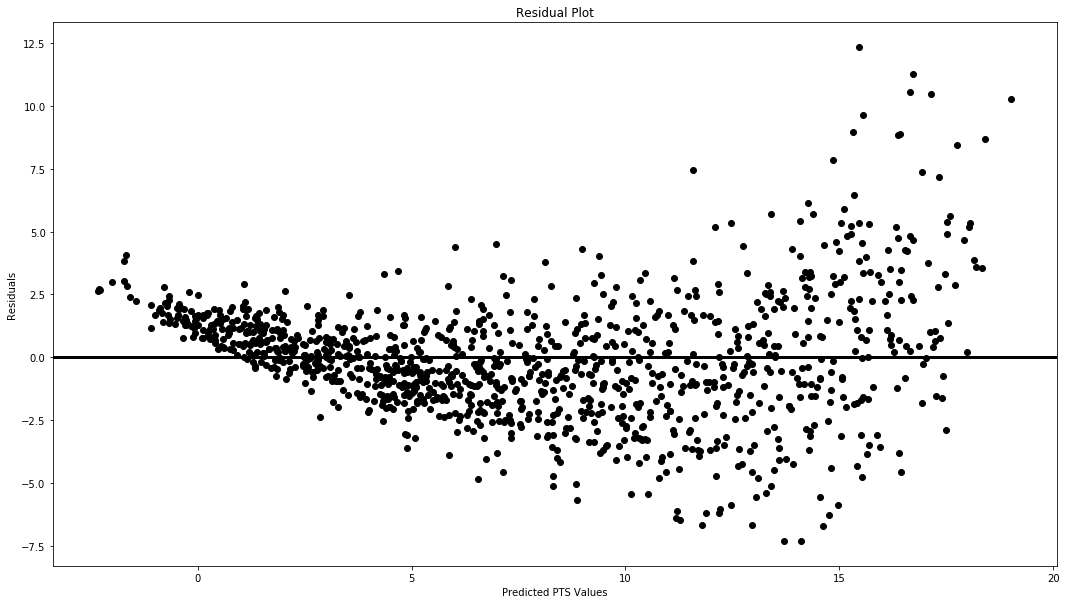

In [3]:
X_eda=player_data_df[["Draft Placing", "eFG%", "Age", "MP"]] # creating a dataframe of only the features selected from EDA.
y=player_data_df["PTS"] 
X_train, X_test, y_train, y_test=train_test_split(X_eda, y, test_size=0.3, random_state=42)

clf_pts=LinearRegression().fit(X_train, y_train) 
y_pred=clf_pts.predict(X_test) 

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

Though the R^2 is quite high, the residual plot shows us that our model is biased. That is, the values of the errors in our predicitions (residuals) are not independant of the predicted values. Furthermore there is distinct increase in the spread of the residuals as well as a U-shape. All of the prior mean that perhaps we need to transform our data to achieve a model that fits the data better. The next logical step would be include polynomial transformations of the existing features. Given the scatter plots of the independant variables against PTS, we saw at most 1 point of inflection, this means we only need to consider 2nd order polynomials. Another consideration is the curse of dimentionality that would arise if we considered 3rd order polynomial features. Let us try this approach and see if our model performs better.

Training performance (R^2): 0.858
Testing performance (R^2): 0.862
R^2 cross val mean: 0.855
95% confidence interval for R^2: (0.838, 0.872)
Mean Squared Error (MSE): 4.383

Some test prints:
Actual: 2.50	  Predicted: 3.37	Difference (absolute): 0.869
Actual: 18.30	  Predicted: 18.05	Difference (absolute): 0.252
Actual: 3.40	  Predicted: 4.59	Difference (absolute): 1.189
Actual: 5.10	  Predicted: 5.77	Difference (absolute): 0.673
Actual: 3.00	  Predicted: 3.02	Difference (absolute): 0.017
Actual: 1.50	  Predicted: 1.75	Difference (absolute): 0.249
Actual: 1.10	  Predicted: 1.73	Difference (absolute): 0.631
Actual: 8.50	  Predicted: 7.64	Difference (absolute): 0.856
Actual: 1.70	  Predicted: 2.61	Difference (absolute): 0.911
Actual: 11.80	  Predicted: 17.11	Difference (absolute): 5.306
Actual: 0.80	  Predicted: 0.64	Difference (absolute): 0.155
Actual: 21.00	  Predicted: 16.43	Difference (absolute): 4.573
Actual: 2.50	  Predicted: 3.23	Difference (absolute): 0.727
Actual: 17.20	  Predic

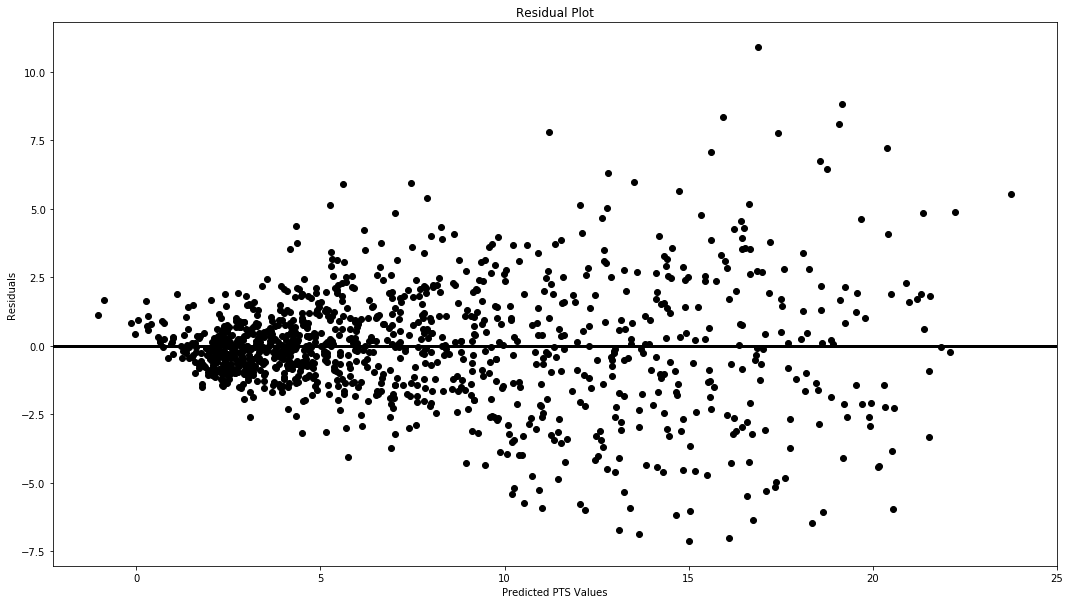

In [4]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["PTS"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

By introducing polynomial features we have succeeded in reducing bias (as demonstrated by a more random residual plot) and also reduced the MSE from 5.7 to 4.3. Also, having computed 5-fold cross validation we can be confident in our model's ability to generalise to unseen data. We will now consider all the features from the dataframe (up to 2nd order polynomial features) and let the selector pick the best 15 to use in the model (15 was chosen arbitrarily).

Training performance (R^2): 0.894
Testing performance (R^2): 0.894
R^2 cross val mean: 0.891
95% confidence interval for R^2: (0.883, 0.900)
Mean Squared Error (MSE): 3.378

Some test prints:
Actual: 2.50	  Predicted: 4.71	Difference (absolute): 2.211
Actual: 18.30	  Predicted: 17.54	Difference (absolute): 0.755
Actual: 3.40	  Predicted: 4.01	Difference (absolute): 0.612
Actual: 5.10	  Predicted: 5.92	Difference (absolute): 0.820
Actual: 3.00	  Predicted: 2.63	Difference (absolute): 0.370
Actual: 1.50	  Predicted: 1.52	Difference (absolute): 0.022
Actual: 1.10	  Predicted: 1.69	Difference (absolute): 0.586
Actual: 8.50	  Predicted: 7.89	Difference (absolute): 0.612
Actual: 1.70	  Predicted: 2.86	Difference (absolute): 1.159
Actual: 11.80	  Predicted: 17.21	Difference (absolute): 5.409
Actual: 0.80	  Predicted: 0.74	Difference (absolute): 0.055
Actual: 21.00	  Predicted: 19.73	Difference (absolute): 1.268
Actual: 2.50	  Predicted: 3.62	Difference (absolute): 1.117
Actual: 17.20	  Predic

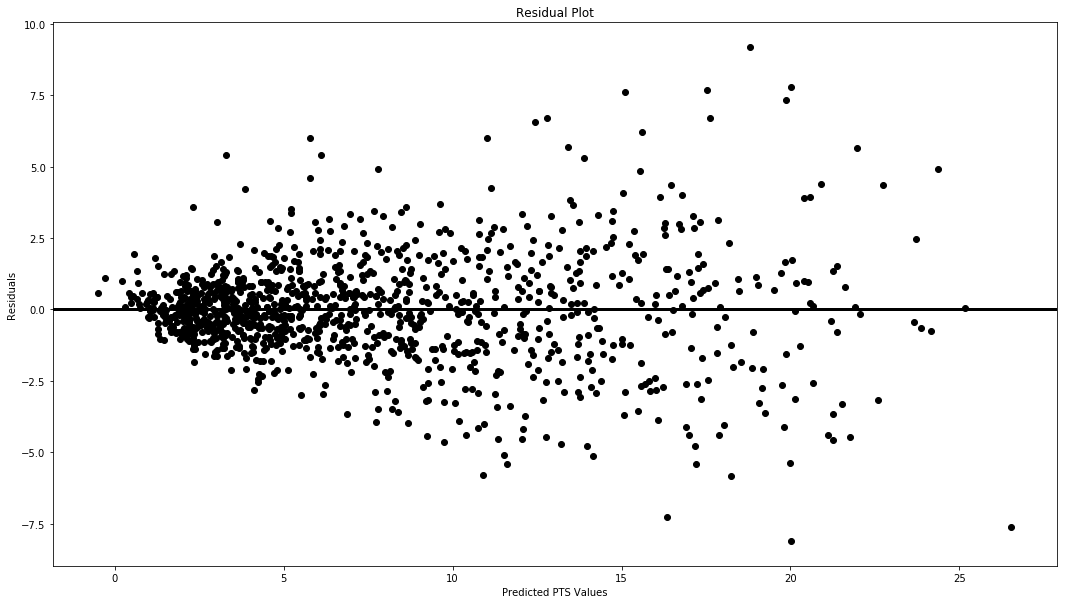

In [5]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]])
y=player_data_df["PTS"]
#y = boxcox(player_data_df["PTS"].values)[0]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feats=SFS(LinearRegression(), k_features=15, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).fit(X_train, y_train)

X_train, X_test, y_train, y_test=train_test_split(X[:,feats.k_feature_idx_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training performance (R^2): 0.905
Testing performance (R^2): 0.898
R^2 cross val mean: 0.896
95% confidence interval for R^2: (0.884, 0.908)
Mean Squared Error (MSE): 3.236

Some test prints:
Actual: 2.50	  Predicted: 4.99	Difference (absolute): 2.486
Actual: 18.30	  Predicted: 18.50	Difference (absolute): 0.199
Actual: 3.40	  Predicted: 3.60	Difference (absolute): 0.201
Actual: 5.10	  Predicted: 6.09	Difference (absolute): 0.987
Actual: 3.00	  Predicted: 2.41	Difference (absolute): 0.588
Actual: 1.50	  Predicted: 1.56	Difference (absolute): 0.062
Actual: 1.10	  Predicted: 1.45	Difference (absolute): 0.349
Actual: 8.50	  Predicted: 7.20	Difference (absolute): 1.301
Actual: 1.70	  Predicted: 2.53	Difference (absolute): 0.831
Actual: 11.80	  Predicted: 17.51	Difference (absolute): 5.710
Actual: 0.80	  Predicted: 0.89	Difference (absolute): 0.091
Actual: 21.00	  Predicted: 17.98	Difference (absolute): 3.018
Actual: 2.50	  Predicted: 3.72	Difference (absolute): 1.216
Actual: 17.20	  Predic

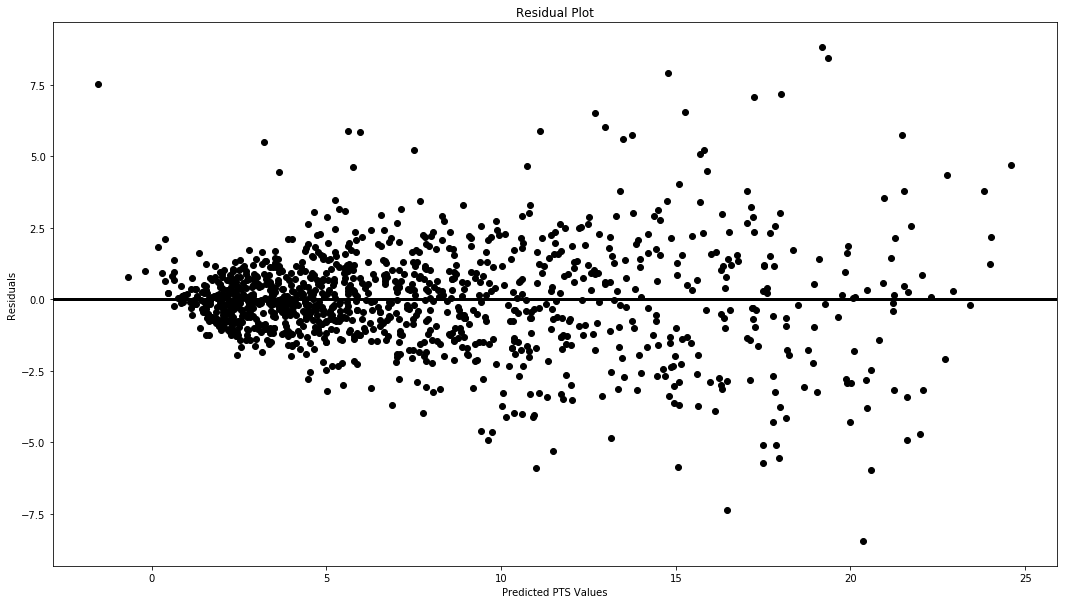

In [17]:
player_data_pts, transformed_columns=my_normalizer(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]], columns_print=True)
player_data_pts=player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]]
poly_feat=PolynomialFeatures(degree=2).fit(player_data_pts)
X=poly_feat.transform(player_data_pts)
y=player_data_df["PTS"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
"""for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]].columns), feat_selector.ranking_):
   print(name, rank)"""
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")
#my_resid_plots(y_test, y_pred, X_test=X_test, columns=player_data_pts.columns)

## Assists per Game (AST column) Model

Training performance (R^2): 0.610
Testing performance (R^2): 0.610
R^2 cross val mean: 0.607
95% confidence interval for R^2: (0.555, 0.658)
Mean Squared Error (MSE): 0.310

Some test prints:
Actual: 0.10	  Predicted: 0.38	Difference (absolute): 0.283
Actual: 1.80	  Predicted: 2.79	Difference (absolute): 0.989
Actual: 0.50	  Predicted: 0.61	Difference (absolute): 0.107
Actual: 0.90	  Predicted: 0.78	Difference (absolute): 0.124
Actual: 0.40	  Predicted: 0.47	Difference (absolute): 0.070
Actual: 0.20	  Predicted: 0.23	Difference (absolute): 0.027
Actual: 0.30	  Predicted: 0.28	Difference (absolute): 0.023
Actual: 1.80	  Predicted: 1.53	Difference (absolute): 0.268
Actual: 0.20	  Predicted: 0.30	Difference (absolute): 0.102
Actual: 2.70	  Predicted: 2.59	Difference (absolute): 0.111
Actual: 0.00	  Predicted: 0.06	Difference (absolute): 0.058
Actual: 2.00	  Predicted: 1.96	Difference (absolute): 0.041
Actual: 0.80	  Predicted: 0.40	Difference (absolute): 0.401
Actual: 1.20	  Predicted: 2.

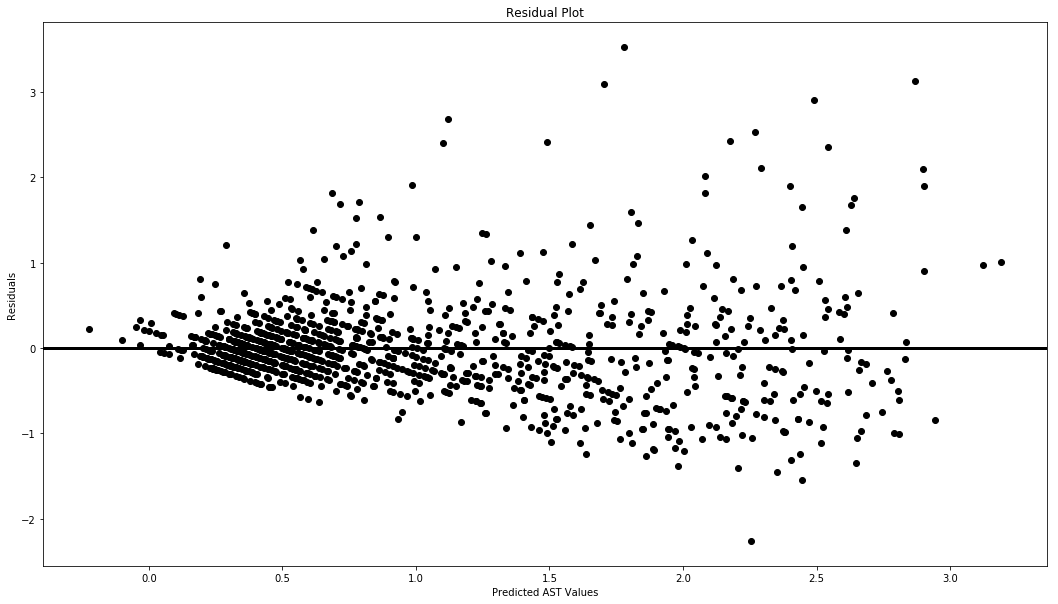

In [8]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["AST"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training performance (R^2): 0.775
Testing performance (R^2): 0.732
R^2 cross val mean: 0.736
95% confidence interval for R^2: (0.705, 0.768)
Mean Squared Error (MSE): 0.213

Some test prints:
Actual: 0.10	  Predicted: 0.76	Difference (absolute): 0.656
Actual: 1.80	  Predicted: 3.10	Difference (absolute): 1.298
Actual: 0.50	  Predicted: 0.35	Difference (absolute): 0.150
Actual: 0.90	  Predicted: 0.83	Difference (absolute): 0.069
Actual: 0.40	  Predicted: 0.38	Difference (absolute): 0.020
Actual: 0.20	  Predicted: 0.23	Difference (absolute): 0.027
Actual: 0.30	  Predicted: 0.24	Difference (absolute): 0.060
Actual: 1.80	  Predicted: 1.82	Difference (absolute): 0.018
Actual: 0.20	  Predicted: 0.32	Difference (absolute): 0.125
Actual: 2.70	  Predicted: 2.44	Difference (absolute): 0.256
Actual: 0.00	  Predicted: -0.09	Difference (absolute): 0.086
Actual: 2.00	  Predicted: 2.06	Difference (absolute): 0.064
Actual: 0.80	  Predicted: 0.49	Difference (absolute): 0.312
Actual: 1.20	  Predicted: 1

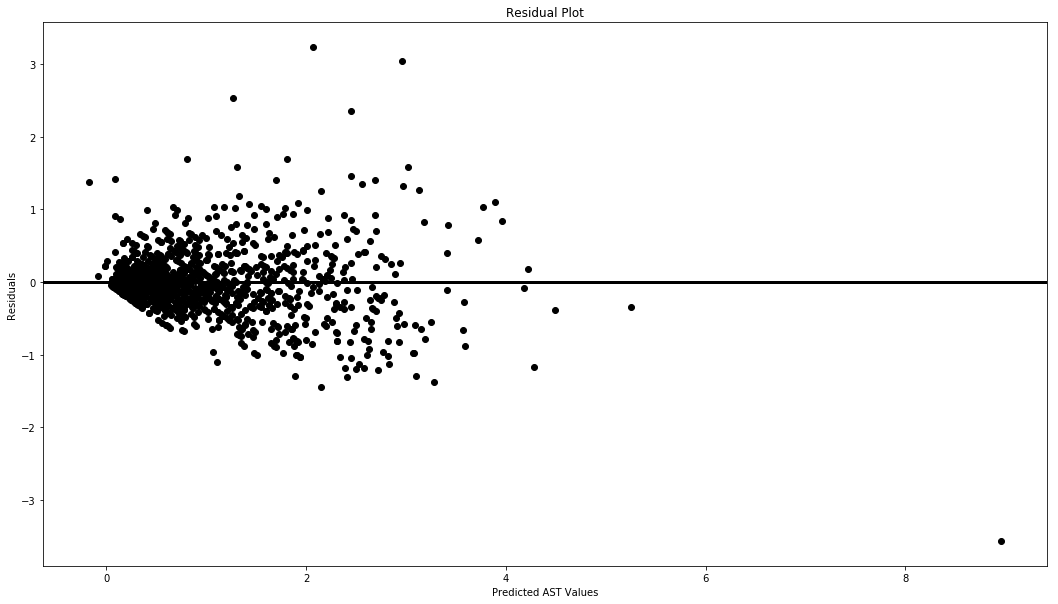

In [9]:
"""X=player_data_df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]]
y=player_data_df.AST
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
X_train, X_test, y_train, y_test=train_test_split(X.iloc[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)


performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")
my_resid_plots(y_test, y_pred, X_test=X_test.values, columns=X_test.columns)


"""
player_data_ast=my_normalizer(player_data_df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]])
poly_feat=PolynomialFeatures(degree=2).fit(player_data_ast)
X=poly_feat.transform(player_data_ast)
y=player_data_df.AST

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
"""for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]].columns), feat_selector.ranking_):
   print(name, rank)"""
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")

**INSERT ASSIST COMMENTS HERE**


## Total Rebounds per Game (TRB column) Model

Training performance (R^2): 0.874
Testing performance (R^2): 0.877
R^2 cross val mean: 0.856
95% confidence interval for R^2: (0.830, 0.883)
Mean Squared Error (MSE): 1.049

Some test prints:
Actual: 1.50	  Predicted: 3.00	Difference (absolute): 1.498
Actual: 9.10	  Predicted: 9.93	Difference (absolute): 0.833
Actual: 3.70	  Predicted: 4.16	Difference (absolute): 0.462
Actual: 3.80	  Predicted: 4.33	Difference (absolute): 0.527
Actual: 2.00	  Predicted: 2.65	Difference (absolute): 0.648
Actual: 1.40	  Predicted: 1.52	Difference (absolute): 0.121
Actual: 1.90	  Predicted: 1.69	Difference (absolute): 0.214
Actual: 2.70	  Predicted: 3.62	Difference (absolute): 0.923
Actual: 1.50	  Predicted: 1.69	Difference (absolute): 0.190
Actual: 11.80	  Predicted: 9.25	Difference (absolute): 2.546
Actual: 0.80	  Predicted: 0.90	Difference (absolute): 0.096
Actual: 11.10	  Predicted: 9.30	Difference (absolute): 1.800
Actual: 2.70	  Predicted: 2.69	Difference (absolute): 0.014
Actual: 6.20	  Predicted: 

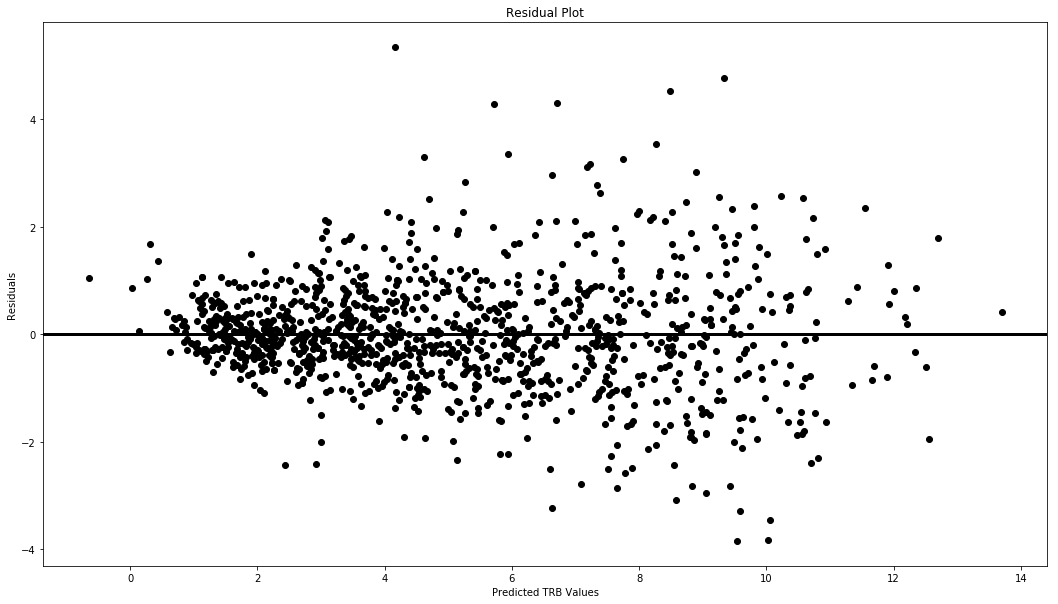

In [23]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,9,10,12]])
y=player_data_df["TRB"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_trb=LinearRegression().fit(X_train, y_train)
y_pred=clf_trb.predict(X_test)

performance_prints(clf_trb, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="TRB")

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training performance (R^2): 0.873
Testing performance (R^2): 0.878
R^2 cross val mean: 0.855
95% confidence interval for R^2: (0.832, 0.878)
Mean Squared Error (MSE): 1.043

Some test prints:
Actual: 1.50	  Predicted: 2.69	Difference (absolute): 1.190
Actual: 9.10	  Predicted: 9.62	Difference (absolute): 0.519
Actual: 3.70	  Predicted: 4.09	Difference (absolute): 0.389
Actual: 3.80	  Predicted: 4.41	Difference (absolute): 0.608
Actual: 2.00	  Predicted: 2.72	Difference (absolute): 0.722
Actual: 1.40	  Predicted: 1.49	Difference (absolute): 0.089
Actual: 1.90	  Predicted: 1.63	Difference (absolute): 0.271
Actual: 2.70	  Predicted: 3.63	Difference (absolute): 0.929
Actual: 1.50	  Predicted: 1.65	Difference (absolute): 0.154
Actual: 11.80	  Predicted: 9.00	Difference (absolute): 2.800
Actual: 0.80	  Predicted: 0.83	Difference (absolute): 0.027
Actual: 11.10	  Predicted: 9.26	Difference (absolute): 1.840
Actual: 2.70	  Predicted: 2.59	Difference (absolute): 0.108
Actual: 6.20	  Predicted: 

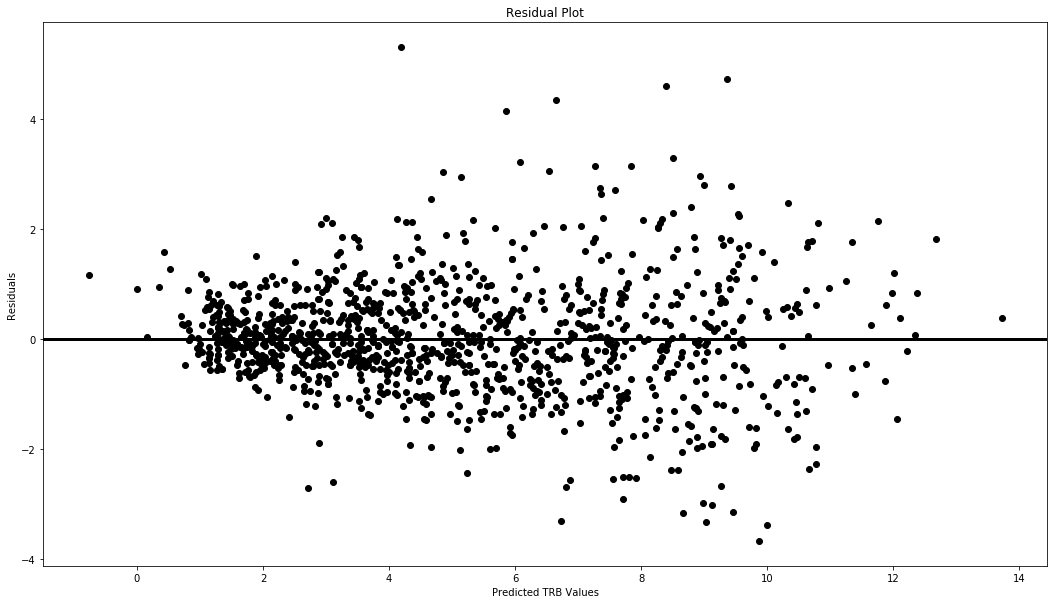

In [22]:
player_data_trb=my_normalizer(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,9,10,12]])
poly_feat=PolynomialFeatures(degree=2).fit(player_data_trb)
X=poly_feat.transform(player_data_trb)
y=player_data_df.TRB

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_trb=LinearRegression().fit(X_train, y_train)
y_pred=clf_trb.predict(X_test)

performance_prints(clf_trb, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="TRB")

Like in the PTS model case, the residuals are roughly randomly distributed, however for higher predicted values we see a larger variance in the residuals.

## Blocks per Game (BLK column) Model

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training performance (R^2): 0.431
Testing performance (R^2): 0.410
R^2 cross val mean: 0.423
95% confidence interval for R^2: (0.379, 0.467)
Mean Squared Error (MSE): 0.279

Some test prints:
Actual: 0.10	  Predicted: 0.45	Difference (absolute): 0.351
Actual: 0.70	  Predicted: 1.48	Difference (absolute): 0.778
Actual: 2.00	  Predicted: 0.62	Difference (absolute): 1.377
Actual: 0.20	  Predicted: 0.69	Difference (absolute): 0.493
Actual: 0.30	  Predicted: 0.32	Difference (absolute): 0.018
Actual: 0.20	  Predicted: 0.16	Difference (absolute): 0.037
Actual: 0.30	  Predicted: 0.11	Difference (absolute): 0.193
Actual: 0.90	  Predicted: 0.55	Difference (absolute): 0.350
Actual: 0.40	  Predicted: 0.30	Difference (absolute): 0.105
Actual: 0.20	  Predicted: 1.52	Difference (absolute): 1.323
Actual: 0.20	  Predicted: 0.03	Difference (absolute): 0.171
Actual: 2.40	  Predicted: 1.74	Difference (absolute): 0.663
Actual: 0.50	  Predicted: 0.32	Difference (absolute): 0.183
Actual: 1.40	  Predicted: 1.

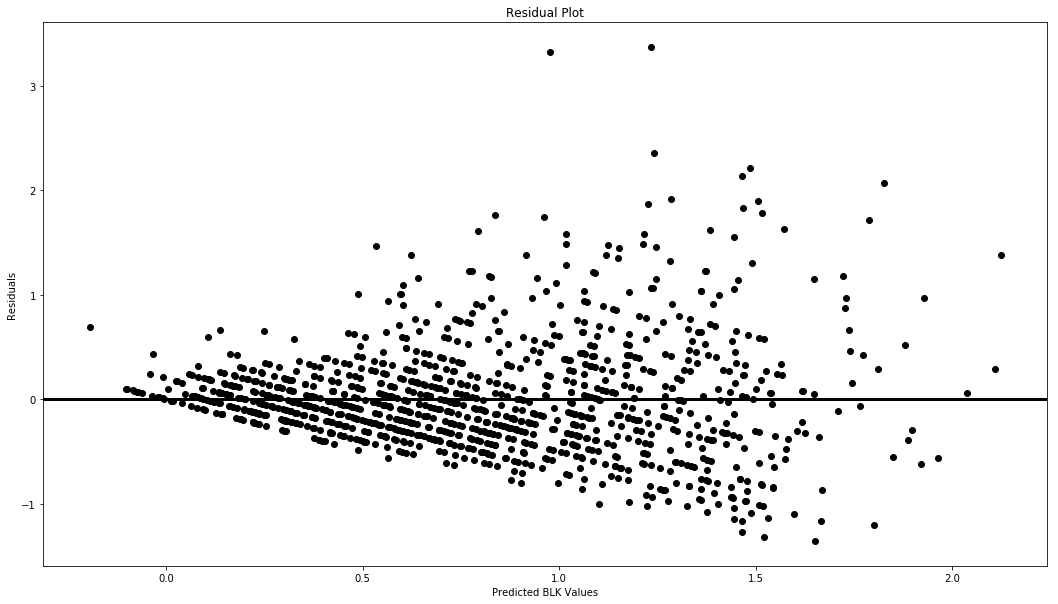

In [76]:
X=my_normalizer(player_data_df.iloc[:,[0,2,3,5,6,8,10,11]])
y=player_data_df.BLK

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
clf_blk=LinearRegression().fit(X_train, y_train)
y_pred=clf_blk.predict(X_test)

performance_prints(clf_blk, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="BLK")
#my_resid_plots(y_test, y_pred, X_test=X_test.values, columns=X_test.columns)

This is totally horrible, we need to do something different.

## Steals per Game (STL column) Model

Training performance (R^2): 0.620
Testing performance (R^2): 0.631
R^2 cross val mean: 0.615
95% confidence interval for R^2: (0.565, 0.665)
Mean Squared Error (MSE): 0.041

Some test prints:
Actual: 0.50	  Predicted: 0.21	Difference (absolute): 0.287
Actual: 0.90	  Predicted: 0.88	Difference (absolute): 0.022
Actual: 0.20	  Predicted: 0.33	Difference (absolute): 0.135
Actual: 0.40	  Predicted: 0.46	Difference (absolute): 0.064
Actual: 0.20	  Predicted: 0.26	Difference (absolute): 0.057
Actual: 0.20	  Predicted: 0.15	Difference (absolute): 0.053
Actual: 0.10	  Predicted: 0.15	Difference (absolute): 0.052
Actual: 1.00	  Predicted: 0.62	Difference (absolute): 0.381
Actual: 0.10	  Predicted: 0.18	Difference (absolute): 0.078
Actual: 1.30	  Predicted: 1.04	Difference (absolute): 0.263
Actual: 0.20	  Predicted: 0.06	Difference (absolute): 0.137
Actual: 0.90	  Predicted: 0.85	Difference (absolute): 0.048
Actual: 0.40	  Predicted: 0.28	Difference (absolute): 0.116
Actual: 0.30	  Predicted: 0.

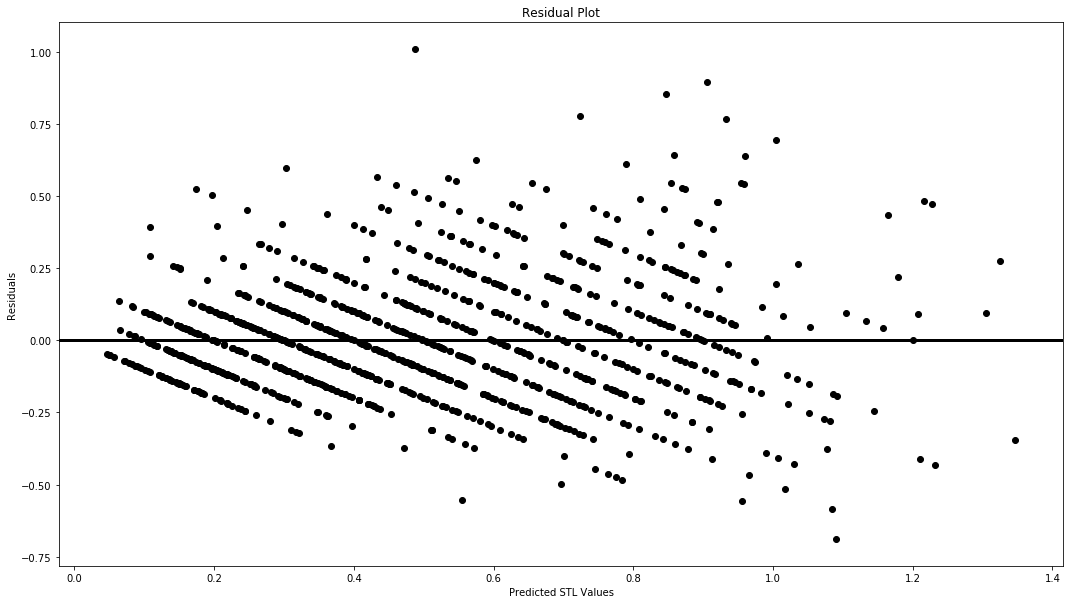

In [74]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,12]])
X=player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,12]]
y=player_data_df.STL
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_stl=LinearRegression().fit(X_train, y_train)
y_pred=clf_stl.predict(X_test)

performance_prints(clf_stl, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="STL")

C:\Users\Lukas Buteliauskas\Anaconda3_\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training performance (R^2): 0.661
Testing performance (R^2): 0.637
R^2 cross val mean: 0.635
95% confidence interval for R^2: (0.586, 0.684)
Mean Squared Error (MSE): 0.041

Some test prints:
Actual: 0.50	  Predicted: 0.19	Difference (absolute): 0.310
Actual: 0.90	  Predicted: 0.82	Difference (absolute): 0.079
Actual: 0.20	  Predicted: 0.33	Difference (absolute): 0.125
Actual: 0.40	  Predicted: 0.46	Difference (absolute): 0.058
Actual: 0.20	  Predicted: 0.25	Difference (absolute): 0.052
Actual: 0.20	  Predicted: 0.12	Difference (absolute): 0.081
Actual: 0.10	  Predicted: 0.14	Difference (absolute): 0.041
Actual: 1.00	  Predicted: 0.77	Difference (absolute): 0.231
Actual: 0.10	  Predicted: 0.14	Difference (absolute): 0.041
Actual: 1.30	  Predicted: 0.98	Difference (absolute): 0.323
Actual: 0.20	  Predicted: 0.07	Difference (absolute): 0.129
Actual: 0.90	  Predicted: 1.06	Difference (absolute): 0.157
Actual: 0.40	  Predicted: 0.26	Difference (absolute): 0.141
Actual: 0.30	  Predicted: 0.

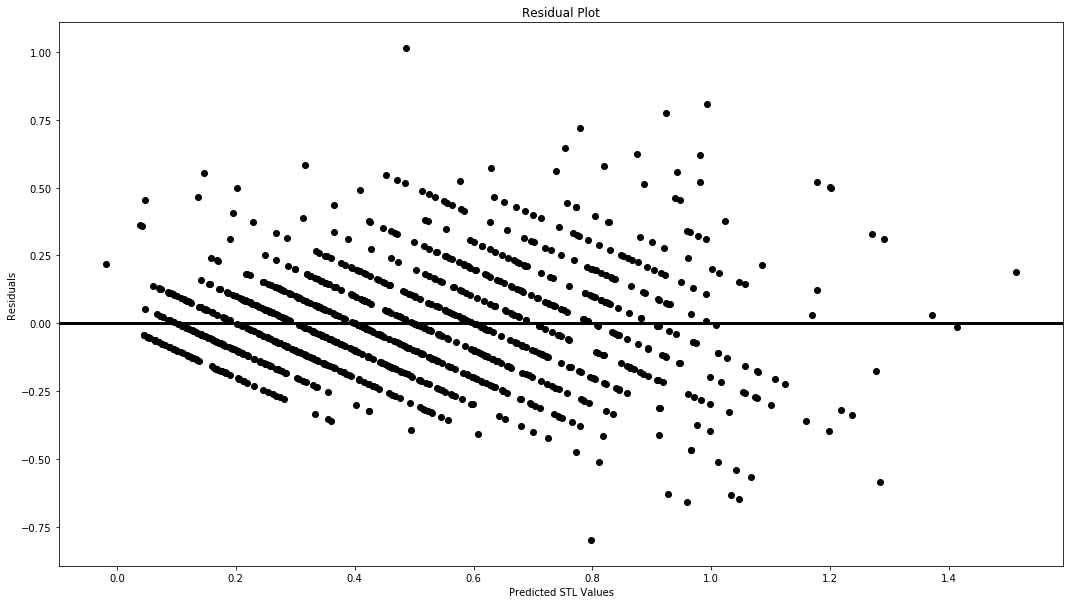

In [75]:
player_data_stl=my_normalizer(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,12]])
poly_feat=PolynomialFeatures(degree=2).fit(player_data_stl)
X=poly_feat.transform(player_data_stl)
y=player_data_df.STL

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
"""for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,12]].columns), feat_selector.ranking_):
   print(name, rank)"""
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_stl=LinearRegression().fit(X_train, y_train)
y_pred=clf_stl.predict(X_test)

performance_prints(clf_stl, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="STL")